[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IBM/ICX360/blob/main/examples/mexgen/quick_start.ipynb)


# MExGen Quick Start

This notebook shows a simple example of using MExGen (Multi-Level Explanations for Generative Language Models) to get users started. For more complete examples, please see the notebooks on [question answering](https://github.com/IBM/ICX360/blob/main/examples/mexgen/question_answering.ipynb), [summarization](https://github.com/IBM/ICX360/blob/main/examples/mexgen/summarization.ipynb), and [RAG](https://github.com/IBM/ICX360/blob/main/examples/mexgen/RAG.ipynb).

### Overview of MExGen

The MExGen approach explains generated text by attributing to parts of the input context and quantifying the importance of these parts to the generation. The following figure shows the workflow of the method. In this ilustrative example, given the context $x$ (Text Input), the question ("Where was Beyonce born?") and the model response ("She was born and raised in Houston"), the method attributes to the parts of the context that were responsible for the model response. This is achieved by first dividing the context into multiple units, generating perturbations (here by excluding some units of text), and using a "scalarizer" to compare the responses from the model with perturbed contexts to the original response. Finally, an algorithm ("Post Hoc Explainer") aggregates the scalar outputs to produce an importance score for each unit of the context. 
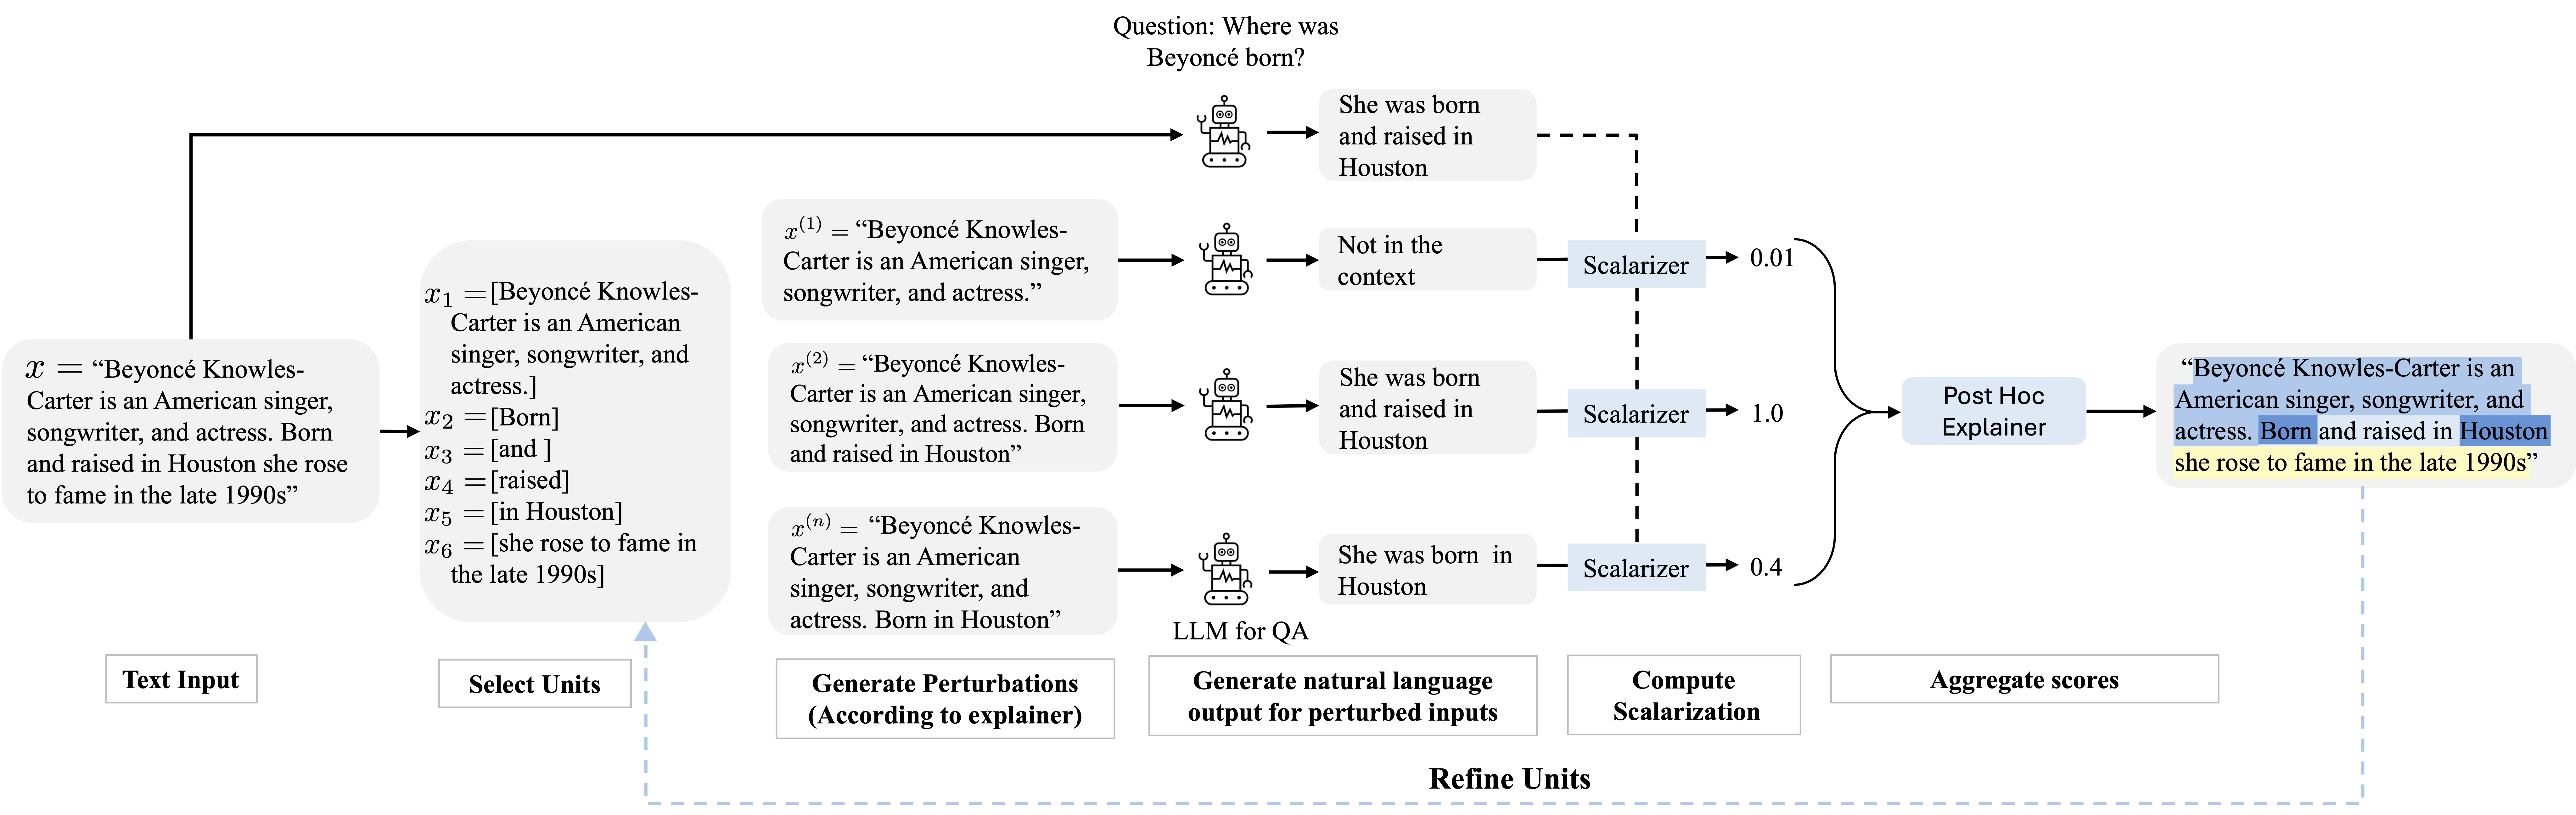

The method and the codebase support different ways of segmenting the context, scalarizing outputs, and aggregating scores. Please see the [paper](https://arxiv.org/abs/2403.14459v1) for more details.

### Install ICX360 for Colab - skip if you have ICX360 installed

**Note for Google Colab:** Switch to a GPU runtime for faster execution.

In [ ]:
# Clone the repository after removing the old copy if any
!rm -rf ICX360
!git clone https://github.com/IBM/ICX360.git

# Install the package
%cd ICX360
!pip install uv
!uv pip install .
%cd ..

### Import packages

Standard packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizerFast

ICX360 classes and functions

In [ ]:
from icx360.algorithms.mexgen import CLIME    # explainer
from icx360.utils.coloring_utils import color_units    # highlight and display text
from icx360.utils.general_utils import select_device    # set device automatically
from icx360.utils.model_wrappers import HFModel    # model wrapper

In [ ]:
device = select_device()
display(device)

device(type='mps')

### Load input

The task for this example is summarization, using a document from the Extreme Summarization (XSum) dataset. For convenience, the document is hard-coded below as a string.

In [ ]:
document = """On Thursday, a human skull was found alongside the M54 slip road by workers doing a survey of the junction four roundabout, near Telford.
Police confirmed the skull was that of an adult male and had been there for at least two years.
West Mercia Police said "further skeletal remains" were found close to the skull.
The eastbound entry slip road remains partially closed.
Det Chief Insp Neil Jamieson said: "We are in the very early stages of this investigation and inquiries are ongoing."
He said further forensic examinations and excavations were being carried out and police had been in contact with neighbouring forces asking for information about people who had been reported missing.
Archaeological experts may be called in to help with the investigation.
"This will be a lengthy process but we will continue to update the public in due course," he added."""
print(document)

On Thursday, a human skull was found alongside the M54 slip road by workers doing a survey of the junction four roundabout, near Telford.
Police confirmed the skull was that of an adult male and had been there for at least two years.
West Mercia Police said "further skeletal remains" were found close to the skull.
The eastbound entry slip road remains partially closed.
Det Chief Insp Neil Jamieson said: "We are in the very early stages of this investigation and inquiries are ongoing."
He said further forensic examinations and excavations were being carried out and police had been in contact with neighbouring forces asking for information about people who had been reported missing.
Archaeological experts may be called in to help with the investigation.
"This will be a lengthy process but we will continue to update the public in due course," he added.


The document can also be retrieved from the dataset (and other examples can be loaded) by uncommenting the following cell:

In [ ]:
# from datasets import load_dataset
# dataset = load_dataset('xsum', split='test', trust_remote_code=True)
# document = dataset["document"][88]
# print(document)

### Load model to explain

We will use a small summarization model from Hugging Face that can be run on a CPU only (although a GPU would be significantly faster).

In [ ]:
model_name = "sshleifer/distilbart-xsum-12-6"
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
tokenizer = BartTokenizerFast.from_pretrained(model_name, add_prefix_space=True)

We wrap the model with a common API (`HFModel`) that the explainer will use.

In [ ]:
wrapped_model = HFModel(model, tokenizer)

### Instantiate explainer

Below we instantiate a MExGen C-LIME explainer. This explainer attributes an importance score to each part of the input document by calling the summarization model on perturbed versions of the input. Parameters for the explainer:
- `scalarizer`: The explainer requires a "scalarizer" to quantify how different are the output summaries for perturbed inputs from the output summary for the original input. For this we use the `"prob"` scalarizer, which computes the probability of generating the original output conditioned on perturbed inputs.
- `segmenter`: The explainer will use the spaCy model `"en_core_web_sm"` to segment the document into sentences.

In [ ]:
explainer = CLIME(wrapped_model, scalarizer="prob", segmenter="en_core_web_sm")

### Call explainer

We call the explainer's `explain_instance` method on the input document with default parameters. This will attribute an importance score to each sentence in the document. (This may take a minute if running on a CPU.)

In [ ]:
output_dict = explainer.explain_instance(document)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


### Look at output

The explainer returns a dictionary. The `"output_orig"` item shows the output summary for the original document.

In [ ]:
display(output_dict["output_orig"].output_text)

['Police investigating the discovery of a human skull on a motorway in Shropshire have said further skeletal remains have been found.']

The `"attributions"` item is itself a dictionary containing the sentences (`"units"`) that the document has been split into along with their importance scores (`"prob"`). These are displayed below, first as highlighted text, and then as a pandas DataFrame to show the numerical scores.

In [ ]:
color_units(output_dict["attributions"]["units"], output_dict["attributions"]["prob"])

In [ ]:
df1 = pd.DataFrame(output_dict["attributions"])[["units", "prob", "unit_types"]].sort_values(
                                by='prob', ascending=False, inplace=False)
styles = [
    {'selector': '.col0', 'props': [('width', '450px'), ('font-weight', 'bold')]}, # units
    {'selector': '.col1', 'props': [('width', '50px')]}, # prob
    {'selector': '.col2', 'props': [('width', '50px')]}, # unit_types
    ]
styled = df1.style.set_table_styles(styles)

display(styled)

,units,prob,unit_types
2,"West Mercia Police said ""further skeletal remains"" were found close to the skull.",0.629328,s
0,"On Thursday, a human skull was found alongside the M54 slip road by workers doing a survey of the junction four roundabout, near Telford.",0.514590,s
4,"Det Chief Insp Neil Jamieson said: ""We are in the very early stages of this investigation and inquiries are ongoing.",0.030450,s
3,The eastbound entry slip road remains partially closed.,0.022306,s
7,"""This will be a lengthy process but we will continue to update the public in due course,"" he added.",0.009261,s
1,Police confirmed the skull was that of an adult male and had been there for at least two years.,0.008356,s
5,""" He said further forensic examinations and excavations were being carried out and police had been in contact with neighbouring forces asking for information about people who had been reported missing.",0.008152,s
6,Archaeological experts may be called in to help with the investigation.,-0.004774,s


The most important sentence (the one with the most positive score) suggests that the model has closely paraphased text ("further skeletal remains have been found"), while the second most important sentence suggests that it also abstracts concepts ("M54 slip road" --> "motorway").